##  **Faze** - face & gaze detection for attention prediction
#### Shifeng, May 2020
Run the code cells below sequentially. Importing packages might take 10 seconds or so.

In [1]:
import time
import sys
cvpath = "/opt/ros/kinetic/lib/python2.7/dist-packages"
if cvpath in sys.path: sys.path.remove(cvpath)
import cv2
import numpy as np
import matplotlib.pyplot as plt

from util.visualize import plot_all
from util.gaze import vector_to_pitchyaw, pitchyaw_to_vector
from run_with_webcam import *

### Initialize your webcam, '0' is the default

In [2]:
webcam = cv2.VideoCapture(0)

### The Detector
* Run the cell below to get started.
* Two cv2 windows will pop up.
    * *Might be hidden behind this program when launched*

In [3]:
# pixel to cm conversion (image plane)
p = 7./1200
focal_len = 2.7

current_face, landmarks, right_eye, left_eye = None, None, None, None
smooth = 0.7
smooth_z = 0.4

connected = 0
while True:
    _, frame_bgr = webcam.read()
    if frame_bgr is None:
        time.sleep(0.1)
        continue
    connected+=1
    if connected == 1:
        print("webcam connected")
    orig_frame = frame_bgr.copy()
    cv2.imshow("Webcam", orig_frame)
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    frame_h,frame_w, _ = frame.shape

    """smooth face detection (linear)"""
    if len(faces):
        next_face = faces[0]
        if current_face is not None:
            current_face[:2] = smooth * next_face[:2] + (1 - smooth) * current_face[:2]
            current_face[3:] = smooth_z * next_face[3:] + (1 - smooth_z) * current_face[3:]
        else:
            current_face = next_face
    
    """get landmark and gaze"""
    if current_face is not None:
        draw_cascade_face(current_face, orig_frame)
        next_landmarks = detect_landmarks(current_face, gray)

        if landmarks is not None:
            landmarks = next_landmarks * smooth + (1 - smooth) * landmarks
        else:
            landmarks = next_landmarks

        draw_landmarks(landmarks, orig_frame)


        if landmarks is not None:
            eye_samples = segment_eyes(gray, landmarks)

            eye_preds = run_eyenet(eye_samples)
            left_eyes = list(filter(lambda x: x.eye_sample.is_left, eye_preds))
            right_eyes = list(filter(lambda x: not x.eye_sample.is_left, eye_preds))

            if left_eyes:
                left_eye = smooth_eye_landmarks(left_eyes[0], left_eye, smoothing=0.2, gaze_smoothing=0.5)
            if right_eyes:
                right_eye = smooth_eye_landmarks(right_eyes[0], right_eye, smoothing=0.2, gaze_smoothing=0.5)
            
            gaze_vectors = np.empty((2,3))
            for ep in [left_eye, right_eye]:
                for (x, y) in ep.landmarks[16:33]:
                    color = (160, 230, 160)
                    if ep.eye_sample.is_left:
                        color = (230, 160, 160)
                    cv2.circle(orig_frame,(int(round(x)), int(round(y))), 1, color, -1, lineType=cv2.LINE_AA)

                gaze = ep.gaze.copy()
                if ep.eye_sample.is_left:
                    gaze[1] = -gaze[1]
                    gaze_vectors[0,:] = pitchyaw_to_vector(np.expand_dims(gaze,0))
                else:
                    gaze_vectors[1,:] = pitchyaw_to_vector(np.expand_dims(gaze,0))
                util.gaze.draw_gaze(orig_frame, ep.landmarks[-2], gaze, length=60.0, thickness=2)
    
    """plot face"""
    plt_frame = []
    if len(faces):
        
        (x,y,w,h) = current_face
        face_size = abs(w - h)/4 + min(w,h)
        face_distance = 5960/face_size    
        face_img_frame = np.array([(x-frame_w/2)*p, (y-frame_h/2)*p, 2.7])
        face_world_frame = face_img_frame/np.linalg.norm(face_img_frame) * face_distance
        plt_frame = plot_all(face_world_frame, gaze_vectors)
    
    if len(plt_frame):
        cv2.imshow("Plot", plt_frame)

    cv2.imshow("Webcam", orig_frame)
    
    time.sleep(0.02)
    cv2.waitKey(1)

webcam connected


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


KeyboardInterrupt: 

### Release camera and close all cv2 windows at the end

In [4]:
webcam.release()
cv2.destroyAllWindows()

---
# Miscellaneous

## Webcam test

In [5]:
webcam = cv2.VideoCapture(0)

while True:
    _, frame_bgr = webcam.read()
    orig_frame = frame_bgr.copy()
    cv2.imshow("Webcam", orig_frame)
    cv2.waitKey(1)
    time.sleep(0.02)  

KeyboardInterrupt: 

In [7]:
# When everything done, release the capture
webcam.release()
cv2.destroyAllWindows()

## Calibration Stuff
**reference size: 13x13cm**
* 34cm: 170
* 51cm: 120px
* 68cm: 93px
* 73cm: 77px

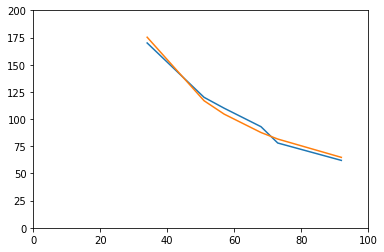

In [68]:
import matplotlib.pyplot as plt
d = np.array([34,51,57,68,73,92])
h = np.array([170,120,110,93,78,62])
y = 5960/d
# for i in range(-10,11):
#     c = (6000 + i*10)
#     y = c/d
#     error = abs(np.sum(h**2 - y**2))**0.5
#     print(c,error)

plt.xlim(0,100)
plt.ylim(0,200)
plt.plot(d,h)
plt.plot(d,y)